In [3]:
#enter date of CDI submission, this connects to folder structure utilized in scripting
date="20200325"

#import libraries
import pandas as pd
import glob, os
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt
import seaborn as sns; sns.set()
import plotly.express as px
import plotly.graph_objs as pgo
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from jupyter_dash import JupyterDash
import dash_bio as dashbio
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output

path = '/Volumes/LabData/CDI HuProt/Raw Data Files/'+date

#read submission excel file
submission=pd.read_excel('/Volumes/LabData/CDI HuProt/Submissions/'+date+'_CDI_HuProt_Submission.xlsx')

#pull hu prot version based on slide 1 and read excel file of huprot version
for file in glob.glob(os.path.join(path,'1_*.xlsx')):
    version_file=pd.read_excel(file, skiprows=5, skip_footer=20000)
version = version_file.columns[0].split('\\')[6]
huprot = pd.read_excel('/Volumes/LabData/Utilities/HuProtVersions/'+version+'.xls')

In [4]:
#create folder structure for outputs that are based on submission date
newpath = r'/Volumes/ProcessData/CDI HuProt/' + date
if not os.path.exists(newpath):
    os.makedirs(newpath)
newpath = r'/Volumes/ProcessData/CDI HuProt/' + date + '/Barcharts'
if not os.path.exists(newpath):
    os.makedirs(newpath)
newpath = r'/Volumes/ProcessData/CDI HuProt/' + date + '/Heatmaps'
if not os.path.exists(newpath):
    os.makedirs(newpath)
newpath = r'/Volumes/ProcessData/CDI HuProt/' + date + '/Excel Outputs'
if not os.path.exists(newpath):
    os.makedirs(newpath)
newpath = r'/Volumes/ProcessData/CDI HuProt/' + date + '/PCA'
if not os.path.exists(newpath):
    os.makedirs(newpath)

In [5]:
path = '/Volumes/LabData/CDI HuProt/Raw Data Files/'+date

#read all raw files associated with CDI submission (based on date)
file_names = []
data_frames= []
df= []
for filename in os.listdir(path):
    name = os.path.splitext(filename)[0]
    name2 = name.split("_")[0]
    file_names.append(filename)
    df = pd.read_excel(path + "/" +filename, skiprows=34)
    df['Slide'] = name2
    df2 = df[['Slide','Block','Column','Row','Name','ID','F635 Median']]
    data_frames.append(df2)
p_data = pd.DataFrame(pd.concat(data_frames))

In [6]:
#df with controls removed (based on ID='Control')
df_noctrl = p_data[~p_data.ID.str.contains("Control")]

#remove all 'ND' samples
df_clean = df_noctrl[~df_noctrl.ID.str.contains("ND")]

#removes TRIM21 due to autoreactivity to IgG Fc
df_clean2 = df_clean[~df_clean['Name'].isin(['TRIM21'])]
df_clean = df_clean2.copy()

#create df of controls only
df_ctrls = p_data[p_data.ID.str.contains("Control")]

In [7]:
#create df of autoantigen targets, based on ID column
auto_antigen_1 = df_clean [df_clean['ID'].str.contains("Auto")]

#create a df of averages for autoantigen targets
auto_antigen = auto_antigen_1[['Name','Slide','F635 Median']]
auto_antigen['Sample'] = auto_antigen['Name'] + "_"+auto_antigen['Slide']
auto_antigen=auto_antigen[['Sample','F635 Median']]
auto_antigen = auto_antigen.groupby(['Sample']).mean()
#auto_antigen=auto_antigen.pivot(index='Name', columns='Slide')

/Users/rayhowanski/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [8]:
auto_antigen = auto_antigen.reset_index()
auto_antigen['Slide'] = auto_antigen.Sample.str.split("_", expand=True)[1]
auto_antigen['Sample'] = auto_antigen.Sample.str.split("_", expand=True)[0]
auto_antigen=auto_antigen.pivot(index='Slide', columns='Sample')
auto_antigen.columns = auto_antigen.columns.droplevel()

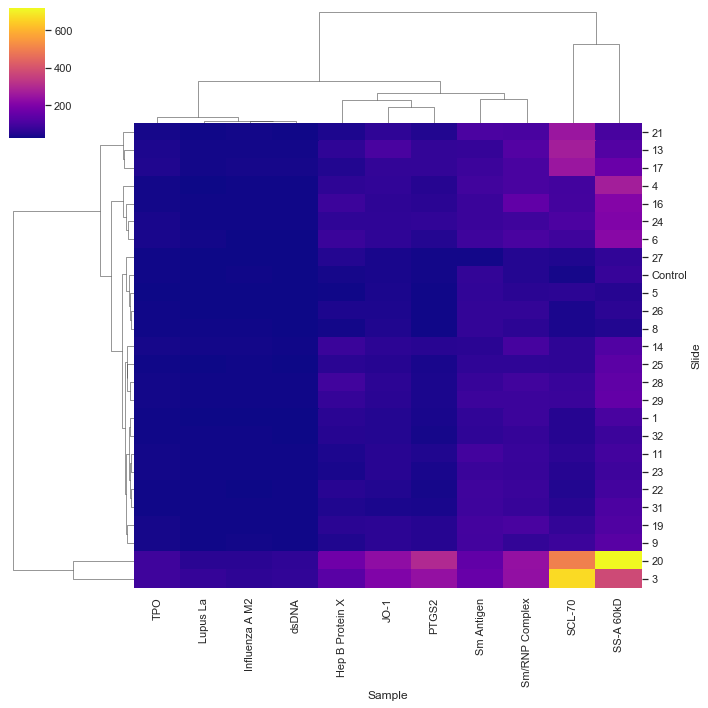

In [9]:
g = sns.clustermap(auto_antigen, cmap='plasma')

In [10]:
slides = df_ctrls["Slide"].unique()
slides = slides.tolist()

In [11]:
for slide in slides:
    test= df_ctrls[df_ctrls.Slide.str.contains(slide)]
    test2 = test.sort_values(by=['Name'])
    fig = px.scatter(test2, x=test2["Name"], y=test2["F635 Median"], hover_data=['Block'], color='Block', title='Slide '+slide+' Control')
    fig.write_html('/Volumes/ProcessData/CDI HuProt/'+date+'/Controls/Slide_'+slide+'_Controls_'+date+'.html', auto_open = False)

In [12]:
df_clean['Slide'] = df_clean['Slide'].str.split('_').str[0]
df_unmelted = df_clean.pivot(index='ID', columns='Slide')
F635 = df_clean[['Slide','ID','F635 Median']]
F635.columns = ['Slide','ID','F635 Mean']
F635_unmelt = F635.pivot(index='ID', columns='Slide')
F635_unmelt2 = F635_unmelt.reset_index()
F635_unmelt2['ID'] = F635_unmelt2['ID'].str.split('.').str[0]
F635_mean = F635_unmelt2.groupby(['ID']).mean()
F635_mean = F635_mean.astype(int)

/Users/rayhowanski/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:3936: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.



In [13]:
F635_mean.columns=F635_mean.columns.droplevel()

In [14]:
#import secondary only slide control (file starts with 'Control_')
for file in glob.glob(os.path.join(path,'Control_*.xlsx')):
    sec_slide = pd.read_excel(file, skiprows=34)

In [15]:
#drop control & ND targets from seconary only slide df
sec_noctrl = sec_slide[~sec_slide.ID.str.contains("Control")]
sec_clean = sec_noctrl[~sec_noctrl.ID.str.contains("ND")]
sec_clean['Slide'] = 'Secondary'

#average the duplicates of the secondary contro slides
sec_clean3 = sec_clean[['ID','F635 Mean']]
sec_clean3['ID'] = sec_clean3['ID'].str.split('.').str[0]
sec_clean2 = sec_clean3.groupby(['ID']).mean().sort_values(by=['F635 Mean'])

#define std dev of secondary only slide
sec_stdev = sec_clean2['F635 Mean'].std()

/Users/rayhowanski/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/rayhowanski/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [16]:
#define targets with secondary above std dev
sec_over = sec_clean2[sec_clean2['F635 Mean'] >= sec_stdev].reset_index()

#definte list of targets with secondary less than std dev and send IDs to list
sec_under = sec_clean2[sec_clean2['F635 Mean'] < sec_stdev].reset_index()
id_list = sec_over['ID'].to_list()

In [17]:
import plotly.express as px
sec_clean_df = sec_clean2.reset_index()
fig = px.violin(sec_clean_df, y="F635 Mean", box=False, points='all', hover_data=['ID'])
fig.add_shape(type='line',
                x0=-0.5,
                y0=sec_stdev,
                x1=0.5,
                y1=sec_stdev,
                line=dict(color='Red',),
                #xref='x',
                #yref='y'
)
fig.write_html('/Volumes/ProcessData/CDI HuProt/'+date+'/'+date+'_HuProt_SecondaryAb_Slide.html', auto_open = False)

In [18]:
#generate excel list of 293
F635_mean_drop = F635_mean.iloc[:, :-1]
F635_mean_drop= F635_mean_drop[~F635_mean_drop.index.isin(id_list)]
exclude_due_to_sec= F635_mean[F635_mean.index.isin(id_list)]
exclude_due_to_sec.to_excel('/Volumes/ProcessData/CDI HuProt/'+date+'/Excel Outputs/'+date+'_Secondary_Binders.xlsx')

In [19]:
kurtosis = F635_mean_drop.astype(int).copy()
kurtosis['Kurtosis']=kurtosis.kurtosis(axis=1)
kurtosis = kurtosis.sort_values(by=['Kurtosis'], ascending=False)

In [20]:
kurt_top100 = kurtosis.iloc[:,:-1].head(100)

In [21]:
#generate df of z score
F635_mean_zscore = F635_mean_drop.copy()
cols = F635_mean_drop.columns.tolist()
for col in cols:
    col_zscore = col + '_zscore'
    F635_mean_zscore[col_zscore] = (F635_mean_zscore[col] - F635_mean_zscore[col].mean())/F635_mean_zscore[col].std(ddof=0)
zscore = F635_mean_zscore.loc[:,F635_mean_zscore.columns.str.contains('_zscore', case=False)] 

In [22]:
heatmap = pd.merge(zscore, F635_mean['Control'], left_on=zscore.index,right_on=F635_mean.index)

In [23]:
heatmap = heatmap.set_index('key_0')

In [24]:
column_maxes = zscore.max()
df_max = column_maxes.max()
normalized_df = zscore / df_max

In [25]:
#generate dictionary of target names based on JHU ID
jhu_dict3 = sec_clean[['ID','Name']]
jhu_dict3 ['ID'] = jhu_dict3 ['ID'].str.split('.').str[0]
jhu_dict2 = jhu_dict3.drop_duplicates(subset=['ID'])

jhu_dict  = dict(zip(jhu_dict2.ID, jhu_dict2.Name))

/Users/rayhowanski/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [26]:
#replace normalized df jhu id with target name
normalized_df_targets = normalized_df.copy()
normalized_df_targets.index = normalized_df_targets.index.map(jhu_dict )

In [27]:
import seaborn as sns
from matplotlib import pyplot
for col in normalized_df_targets:
    sorted_cols = normalized_df_targets.sort_values(by=[col],ascending=False)
    sorted_cols = sorted_cols.head(15)
    y=sorted_cols.index
    x=sorted_cols.columns
    fig = px.imshow(sorted_cols, labels=dict(x="Slide", y="Target", color="F635 Normalized"),y=y,x=x)
    fig.update_layout(title='Slide '+col+' Heatmap')
    fig.write_html('/Volumes/ProcessData/CDI HuProt/'+date+'/Heatmaps/'+col+'_top15_heatmap.html', auto_open = False)

In [28]:
#replace JHU IDs with target names
heatmap_targets = heatmap.copy()
heatmap_targets.index = heatmap_targets.index.map(jhu_dict )

In [29]:
#drop controls column
target_avg = heatmap_targets.iloc[:,:-1].copy()
#calculate mean zscore of each row
target_avg['mean'] = target_avg.mean(axis=1)

In [30]:
for col in heatmap_targets:
    sorted_cols = heatmap_targets.sort_values(by=[col],ascending=False)
    sorted_cols = sorted_cols.head(50)
    fig = px.bar(sorted_cols, labels=dict(x="Target"),x=sorted_cols.index, y=col, color='Control')
    fig.write_html('/Volumes/ProcessData/CDI HuProt/'+date+'/Barcharts/'+col+'_bar_chart.html', auto_open = False)

In [31]:
kurtosis = target_avg.iloc[:,:-1].copy()
kurtosis['kurtosis'] = kurtosis.kurtosis(axis=1)
kurtosis['zmax'] = kurtosis.iloc[:,:-1].max(axis=1)
kurtosis['kurt_x_zmax'] = kurtosis['kurtosis'] * kurtosis['zmax']
kurtosis = kurtosis.sort_values(by=['kurt_x_zmax'], ascending=False)

In [32]:
kurtosis_output = kurtosis.copy()
kurtosis_output.index.rename('Target')
kurtosis_output.to_excel('/Volumes/ProcessData/CDI HuProt/'+date+'/Excel Outputs/Z_score_array_'+date+'_Output.xlsx')

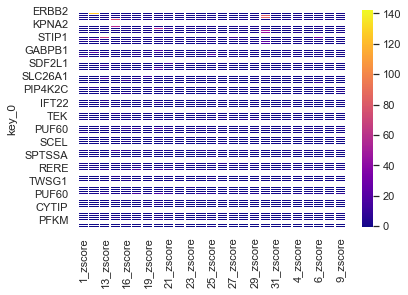

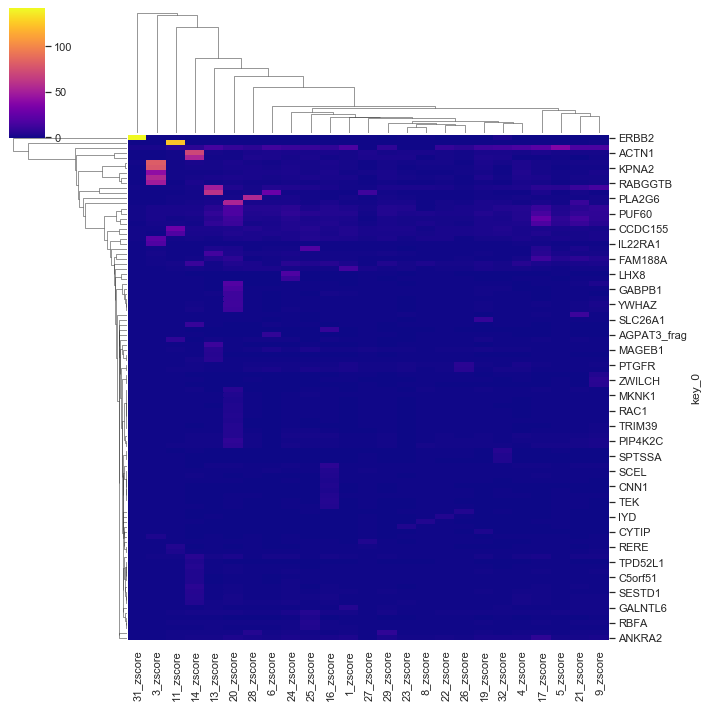

In [33]:
kurtosis_heatmap = kurtosis.iloc[:,:-3]
ax = sns.heatmap(kurtosis_heatmap.head(100), linewidth=0.5, cmap='plasma')
plt.show()
g = sns.clustermap(kurtosis_heatmap.head(100), cmap='plasma')

In [34]:
row_labels = kurtosis_heatmap.head(400).index.tolist()

In [35]:

data = kurtosis_heatmap.head(400).values

component = dcc.Graph(figure=dashbio.Clustergram(
  data=data,
  color_threshold={'row': 150,
  'col': 700}
  #column_labels=kurtosis_heatmap.columns.values
  #row_labels=row_labels.values
  #hidden_labels=['row'],
  #width=600
))

/Users/rayhowanski/opt/anaconda3/lib/python3.7/site-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



data = kurtosis_heatmap.head(400).values

app = JupyterDash(__name__)
app.layout = html.Div([
    html.H1("JupyterDash Demo"),
    dcc.Graph(id='graph'),
    html.Label([
        "colorscale",
        dcc.Graph(figure=dashbio.Clustergram(data=data,color_threshold={'row': 150,'col': 700}
  #column_labels=kurtosis_heatmap.columns.values
  #row_labels=row_labels.values
  #hidden_labels=['row'],
  #width=600
))
])
])
app.run_server(mode='inline')

In [36]:
#remove last 3 columns (kurtosis, z max, kurtosis * z max)
kurtosis_col = kurtosis.iloc[:,:-3]
kurtosis_col = kurtosis_col.head(500)

for col in normalized_df_targets:
    sorted_cols = kurtosis_col.sort_values(by=[col],ascending=False)
    sorted_cols = sorted_cols.head(25)
    y=sorted_cols.index
    x=sorted_cols.columns
    fig = px.imshow(sorted_cols, labels=dict(x="Slide", y="Target", color="F635 Normalized"),y=y,x=x)
    fig.update_layout(title=col+' Heatmap')
    fig.write_html('/Volumes/ProcessData/CDI HuProt/'+date+'/Heatmaps/Slide_'+col+'_Kurtosis_Filtered_Heatmap.html', auto_open = False)

In [62]:
heatmap_targets3 = heatmap_targets.iloc[:,:-1].copy()

In [82]:
# define column names to be useed later, column order needs to be obtained for s score loop 
heatmap_targets2 = heatmap_targets.iloc[:,:-1].copy()



In [83]:
# count number of rows and columns
rows = df.iloc[:,1].count()
column_number = len(heatmap_targets2.columns)

# create list function based on range
def createList(r1, r2): 
    return [item for item in range(r1, r2+1)] 
      
# driver code
r1, r2 = 0, rows-2
row_list= createList(r1, r2)

r1, r2 = 0, column_number-1
col_list = createList(r1, r2)

In [84]:
cols=heatmap_targets2.columns
heatmap_targets2.columns = col_list
columns= heatmap_targets2.columns

In [85]:
heatmap_targets2

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
key_0,,,,,,,,,,,,,,,,,,,,,
Lupus La,1.503469,0.668831,1.398232,0.752674,1.740408,1.564758,1.429778,1.656538,1.858880,1.419299,...,1.781662,1.406573,0.267512,0.254790,2.022112,2.352266,1.190659,2.008719,0.920176,1.450051
FGGY,-0.278465,-0.097192,-0.317249,0.304891,0.028314,0.073292,-0.185943,0.607570,-0.058293,-0.121997,...,-0.340984,-0.013909,-0.027642,0.002930,-0.248033,-0.160401,-0.201835,-0.484349,-0.114846,-0.038555
DGUOK,-0.278465,-0.130497,-0.149065,-0.187672,-0.422237,-0.628574,-0.353087,-0.312073,-0.402402,-0.195392,...,-0.280337,-0.329571,-0.070164,-0.023582,-0.248033,-0.388826,-0.201835,-0.235042,-0.028594,-0.297443
AAK1,-0.349742,0.702136,1.768238,1.200458,1.289857,2.573691,1.429778,1.110500,0.728239,1.199114,...,0.993251,1.196131,0.029888,0.307813,-0.248033,0.524872,0.991731,2.656916,-0.201098,0.802831
ACVR1C,0.576863,0.335778,1.196410,0.663118,1.109637,0.029425,0.928347,1.038653,0.777397,0.391768,...,1.357133,1.511793,0.042395,0.148743,1.341069,1.438569,0.295484,-0.085458,0.057657,0.349777
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NIN,-0.207187,-0.130497,-0.182702,-0.501120,-0.061796,-0.189908,0.371202,-0.355181,-0.107452,-0.048602,...,-0.098396,-0.119129,-0.035145,-0.036838,-0.134526,0.239341,-0.201835,0.213710,-0.114846,-0.362165
SPATA31E1,-0.207187,-0.163802,-0.283613,-0.322007,-0.377182,-0.321508,-0.353087,-0.297703,-0.156610,-0.268787,...,-0.280337,-0.329571,-0.035145,-0.063349,-0.248033,-0.331720,-0.102371,-0.284903,-0.114846,-0.232721
RAPGEF6,-0.278465,-0.130497,-0.182702,-0.501120,-0.377182,-0.321508,-0.408801,-0.326442,-0.254927,-0.268787,...,-0.340984,-0.329571,-0.030143,-0.063349,-0.361540,-0.445932,-0.102371,-0.284903,-0.114846,-0.232721


In [87]:
#calcuate kurtosis, s score based on z scores, generate df for PCA of sample
for col in col_list:
    df = heatmap_targets2.sort_values(by=[col], ascending=False)
    
    #generate row list, but excluding last row; last row will have an s score of 0
    rows = df.iloc[:,1].count()
    r1, r2 = 0, rows-2
    row_list= createList(r1, r2)
    
    #calculate s score by subtrating z score of row below from z score of sample
    scores=[]
    for row in row_list:
        row_below= row+1
        score = df.iloc[row,int(col)] - df.iloc[row_below,int(col)]
        scores.append(score)
    
    #provides last row with an s score of 0
    scores.append(0)
    
    slide = cols[col]
    df.columns= cols
    df['s_score']= scores
    df['kurtosis']=df.iloc[:,:-2].kurtosis(axis=1)
    df = df[[str(slide), 's_score', 'kurtosis']]
    df.index.rename('Target')
    slide2=slide.split('_')[0]
    df.to_excel('/Volumes/ProcessData/CDI HuProt/'+date+'/Excel Outputs/Slide_'+slide2+'_'+date+'_Output.xlsx')
    
    #perform PCA
    X = df
    ID = df.index
    pca = PCA(n_components=3)
    components = pca.fit_transform(X)
    labels = {
        str(i): f"PC {i+1} ({var:.1f}%)"
        for i, var in enumerate(pca.explained_variance_ratio_ * 100)}
    
    #index pca data with targets from df
    pca_data= pd.DataFrame(data=components)
    pca_data['Target'] = df.index
    pca_data.set_index('Target')
    
    #generate pca
    fig = px.scatter_matrix(pca_data,labels=labels,hover_data=['Target'],dimensions=range(3)) #color=PCA_df['Membrane_Protein']
    fig.update_xaxes(title_font = {"size": 14})
    fig.update_traces(diagonal_visible=False)
    fig.write_html('/Volumes/ProcessData/CDI HuProt/'+date+'/PCA/Slide_'+slide2+'_PCA.html', auto_open = False)
    

    def cluster(n_clusters):
        kmeans = KMeans(n_clusters=n_clusters)
        kmeans.fit(X.values)
        Z = kmeans.predict(X.values)
        return kmeans, Z

    #modify number of clusters for k means by changing value of n_clusters
    n_clusters = 3
    model, Z = cluster(n_clusters)


    X_reduced = pca.fit_transform(X)
    
    #convert PCA values to pd df and add associated targets from df index
    df_X_reduced = pd.DataFrame(X_reduced, index=df.index)

    trace0 = pgo.Scatter(x=df_X_reduced[0],
                         y=df_X_reduced[1],
                         text=df.index,
                         name='',
                         mode='markers',
                         marker=pgo.Marker(opacity=0.5,color=Z),
                         showlegend=False)
    layout5 = pgo.Layout(title='(PCA)',
                         xaxis=pgo.XAxis(showgrid=False,
                                         zeroline=False,
                                         showticklabels=False),
                         yaxis=pgo.YAxis(showgrid=False,
                                         zeroline=False,
                                         showticklabels=False),
                         hovermode='closest')
    
    data7 = pgo.Data([trace0])
    layout7 = layout5
    layout7['title'] = 'PCA of Sample ' + slide2 + ' with ' + str(n_clusters) + 'clusters'
    fig7 = pgo.Figure(data=data7, layout=layout7)
    fig7.write_html('/Volumes/ProcessData/CDI HuProt/'+date+'/PCA/Slide_'+slide2+'_PCA_k_means.html', auto_open = False)

/Users/rayhowanski/opt/anaconda3/lib/python3.7/site-packages/plotly/graph_objs/_deprecations.py:441: DeprecationWarning:

plotly.graph_objs.Marker is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Marker
  - plotly.graph_objs.histogram.selected.Marker
  - etc.


/Users/rayhowanski/opt/anaconda3/lib/python3.7/site-packages/plotly/graph_objs/_deprecations.py:550: DeprecationWarning:

plotly.graph_objs.XAxis is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.XAxis
  - plotly.graph_objs.layout.scene.XAxis


/Users/rayhowanski/opt/anaconda3/lib/python3.7/site-packages/plotly/graph_objs/_deprecations.py:578: DeprecationWarning:

plotly.graph_objs.YAxis is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.YAxis
  - plotly.graph_objs.layout.scene.YAxis


/Users/rayhowanski/opt/anaconda3/lib/python3.7/site-packages/plotly/grap

In [92]:
heatmap_targets2.columns = cols
heatmap_targets2['kurtosis'] = heatmap_targets2.kurtosis(axis=1)

,1_zscore,11_zscore,13_zscore,14_zscore,16_zscore,17_zscore,19_zscore,20_zscore,21_zscore,22_zscore,...,29_zscore,3_zscore,31_zscore,32_zscore,4_zscore,5_zscore,6_zscore,8_zscore,9_zscore,kurtosis
key_0,,,,,,,,,,,,,,,,,,,,,
Lupus La,1.503469,0.668831,1.398232,0.752674,1.740408,1.564758,1.429778,1.656538,1.858880,1.419299,...,1.406573,0.267512,0.254790,2.022112,2.352266,1.190659,2.008719,0.920176,1.450051,0.625280
FGGY,-0.278465,-0.097192,-0.317249,0.304891,0.028314,0.073292,-0.185943,0.607570,-0.058293,-0.121997,...,-0.013909,-0.027642,0.002930,-0.248033,-0.160401,-0.201835,-0.484349,-0.114846,-0.038555,3.572516
DGUOK,-0.278465,-0.130497,-0.149065,-0.187672,-0.422237,-0.628574,-0.353087,-0.312073,-0.402402,-0.195392,...,-0.329571,-0.070164,-0.023582,-0.248033,-0.388826,-0.201835,-0.235042,-0.028594,-0.297443,1.161357
AAK1,-0.349742,0.702136,1.768238,1.200458,1.289857,2.573691,1.429778,1.110500,0.728239,1.199114,...,1.196131,0.029888,0.307813,-0.248033,0.524872,0.991731,2.656916,-0.201098,0.802831,-0.339276
ACVR1C,0.576863,0.335778,1.196410,0.663118,1.109637,0.029425,0.928347,1.038653,0.777397,0.391768,...,1.511793,0.042395,0.148743,1.341069,1.438569,0.295484,-0.085458,0.057657,0.349777,-1.117908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NIN,-0.207187,-0.130497,-0.182702,-0.501120,-0.061796,-0.189908,0.371202,-0.355181,-0.107452,-0.048602,...,-0.119129,-0.035145,-0.036838,-0.134526,0.239341,-0.201835,0.213710,-0.114846,-0.362165,0.046202
SPATA31E1,-0.207187,-0.163802,-0.283613,-0.322007,-0.377182,-0.321508,-0.353087,-0.297703,-0.156610,-0.268787,...,-0.329571,-0.035145,-0.063349,-0.248033,-0.331720,-0.102371,-0.284903,-0.114846,-0.232721,-0.527848
RAPGEF6,-0.278465,-0.130497,-0.182702,-0.501120,-0.377182,-0.321508,-0.408801,-0.326442,-0.254927,-0.268787,...,-0.329571,-0.030143,-0.063349,-0.361540,-0.445932,-0.102371,-0.284903,-0.114846,-0.232721,-0.387160


In [97]:
#perform PCA
X = heatmap_targets2
ID = heatmap_targets2.index
pca = PCA(n_components=3)
components = pca.fit_transform(X)
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)}
    
#index pca data with targets from df
pca_data= pd.DataFrame(data=components)
pca_data['Target'] = heatmap_targets2.index
pca_data.set_index('Target')
    
#generate pca
fig = px.scatter_matrix(pca_data,labels=labels,hover_data=['Target'],dimensions=range(3)) #color=PCA_df['Membrane_Protein']
fig.update_xaxes(title_font = {"size": 14})
fig.update_traces(diagonal_visible=False)
fig.write_html('test.html', auto_open = True)

In [96]:
n_clusters = 6
model, Z = cluster(n_clusters)


X_reduced = pca.fit_transform(X)

#convert PCA values to pd df and add associated targets from df index
df_X_reduced = pd.DataFrame(X_reduced, index=df.index)

trace0 = pgo.Scatter(x=df_X_reduced[1],
                     y=df_X_reduced[2],
                     text=heatmap_targets2.index,
                     name='',
                     mode='markers',
                     marker=pgo.Marker(opacity=0.5,color=Z),
                     showlegend=False)
layout5 = pgo.Layout(title='(PCA)',
                     xaxis=pgo.XAxis(showgrid=True,
                                     zeroline=True,
                                     showticklabels=True),
                     yaxis=pgo.YAxis(showgrid=True,
                                     zeroline=True,
                                     showticklabels=True),
                     hovermode='closest')
data7 = pgo.Data([trace0])
layout7 = layout5
layout7['title'] = 'PCA of Sample with ' + str(n_clusters) + 'clusters'
fig7 = pgo.Figure(data=data7, layout=layout7)
fig7.write_html('test.html', auto_open = True)

/Users/rayhowanski/opt/anaconda3/lib/python3.7/site-packages/plotly/graph_objs/_deprecations.py:441: DeprecationWarning:

plotly.graph_objs.Marker is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Marker
  - plotly.graph_objs.histogram.selected.Marker
  - etc.


/Users/rayhowanski/opt/anaconda3/lib/python3.7/site-packages/plotly/graph_objs/_deprecations.py:550: DeprecationWarning:

plotly.graph_objs.XAxis is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.XAxis
  - plotly.graph_objs.layout.scene.XAxis


/Users/rayhowanski/opt/anaconda3/lib/python3.7/site-packages/plotly/graph_objs/_deprecations.py:578: DeprecationWarning:

plotly.graph_objs.YAxis is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.YAxis
  - plotly.graph_objs.layout.scene.YAxis


/Users/rayhowanski/opt/anaconda3/lib/python3.7/site-packages/plotly/grap

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(X)
pca = PCA().fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

target_dict  = dict(zip(huprot.system_ID, huprot.symbol))
targets = heatmap.iloc[:,:-1].reset_index()
targets['Target'] = targets['key_0'].map(target_dict )

cat_dict  = dict(zip(huprot.system_ID, huprot.categories))
categories = heatmap.iloc[:,:-1].reset_index()
categories['Categories'] = categories['key_0'].map(cat_dict)

categories=categories.fillna('No')
categories = categories.astype(str)

categories['Membrane_Protein']="No"
categories['Cell_Death']="No"
categories['Kinase']="No"
categories['Nuclear_Protein']="No"
categories['Transcription_Factor']="No"
categories['Metabolism']="No"
categories['Secreted_Protein']="No"
categories['Signal_Transduction']="No"
categories['Tumor_Antigen']="No"

categories['Membrane_Protein'][categories['Categories'].str.contains("Membrane Protein")] = "Yes"
categories['Cell_Death'][categories['Categories'].str.contains("Cell Death")] = "Yes"
categories['Kinase'][categories['Categories'].str.contains("Kinase")] ="Yes"
categories['Nuclear_Protein'][categories['Categories'].str.contains("Nuclear Protein")] ="Yes"
categories['Transcription_Factor'][categories['Categories'].str.contains("Transcription Factor")] ="Yes"
categories['Metabolism'][categories['Categories'].str.contains("Metabolism")] ="Yes"
categories['Secreted_Protein'][categories['Categories'].str.contains("Secreted Protein")]  ="Yes"
categories['Signal_Transduction'][categories['Categories'].str.contains("Signal Transduction")] ="Yes"
categories['Tumor_Antigen'][categories['Categories'].str.contains("Tumor Antigen")] = "Yes"

categories_top = categories.head(100)

PCA = heatmap.iloc[:,:-1]
PCA_df = PCA.merge(categories_top[['key_0','Membrane_Protein']], left_on="key_0", right_on="key_0")

PCA_df = PCA_df.set_index('key_0')
PCA_df

import plotly.express as px
from sklearn.decomposition import PCA

X = PCA_df.iloc[:,:-1]
#ID = PCA_df.index

pca = PCA(n_components=4)
components = pca.fit_transform(X)
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

fig = px.scatter_matrix(
    components,
    labels=labels,
    dimensions=range(4),
    color=PCA_df['Membrane_Protein']
)

fig.update_xaxes(
        title_font = {"size": 10})
fig.update_traces(diagonal_visible=False)
fig.show()